### Intro to Probabilistic graphical models

PGMs are **generative** models that can compute the joint distribution among random variables in a system by explotiing the conditional indpendence relationship between variables to create a graph structure representing the relationships between different random variables.

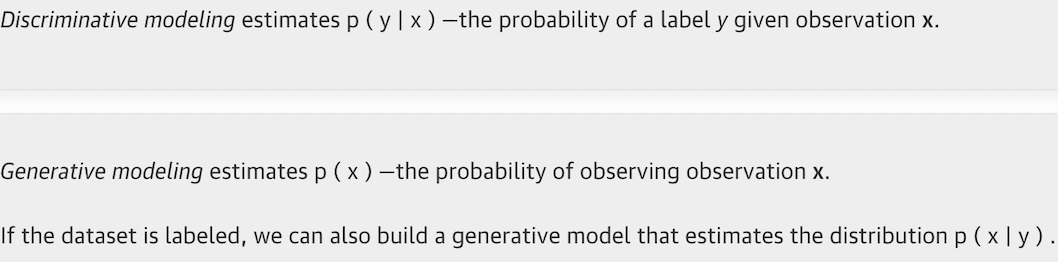

Graph structures can be directed, undirected or both and have a set of parameters associated with each variable (local conditional probabilities).

There are mainly 2 types of graphical models: 

1. Markov Models: A Markov Models consists of an **undirected** graph and are parameterized by **factors**. Factors
represent how much 2 or more variables agree with each other. **Cycles** are permitted in graphs

     e.g. Markov networks, Markov chains, HMM
     

2. Bayesian Models: A Bayesian Model consists of a **directed** and **acyclic** graph (DAG). Each node in the graph has local **Conditional Probability Distributions(CPDs)** to represent causual relationshp with other variables

     e.g. Discrete Bayesian Network, Continuous Bayesian Network, Dynamic BN, Bayesian Classifiers (Naive Bayes)
     

There are other types of probabilistic models which do not belong to either of these classes e.g. Gaussian Mixture Models (commonly used for clustering)

### Markov Chains


A Markov chain is a model that tells us something about the probabilities of sequences of random variables,
states, each of which can take on values from some set. These sets can be words, or
tags, or symbols representing anything, like the weather. A Markov chain makes a
very strong assumption that if we want to predict the future in the sequence, all that
matters is the current state. The states before the current state have no impact on the
future except via the current state. 

                                Markov Assumption: P(Si|S1...Si−1) = P(Si|Si−1)

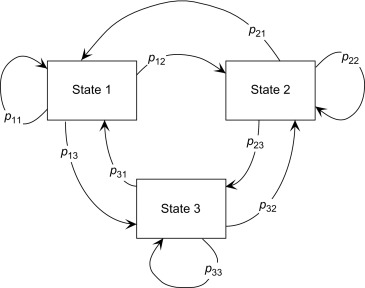

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from pomegranate import ConditionalProbabilityTable, DiscreteDistribution, MarkovChain
import datetime
import os
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from collections import deque 
from matplotlib.dates import YearLocator
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import pandas_datareader.data as web
from matplotlib.dates import MonthLocator, YearLocator
from pgmpy.models import NaiveBayes
import random
import pyvis
from pyvis.network import Network


def initialise_markov_chain(prior_prob, cpd):
    d1 = DiscreteDistribution(prior_prob)
    d2 = ConditionalProbabilityTable(cpd, [d1])
    clf = MarkovChain([d1, d2])
    return clf


def compute_probability_sequence(seq, clf):
    print(clf.log_probability(seq))


def generate_random_sample_from_model(clf, length, num_seqs):
    df = pd.DataFrame(columns=["sequences"])
    for i in range(num_seqs):
        obs = clf.sample(length)
        df = df.append({"sequences": obs}, ignore_index=True)
    return df


def build_markov_chain_from_data(df):
    seq = list(df["sequences"])
    model = MarkovChain.from_samples(seq)
    return model


def create_markov_networkx_object(model):
    cpd = model.distributions[1].to_dict()["table"]
    states = list(model.distributions[0].to_dict()["parameters"][0].keys())
    G = nx.MultiDiGraph()
    G.add_nodes_from(states)
    for k, l, v in cpd:
        tmp_origin, tmp_destination = k, l
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v[0:4])
        color = "red"
       
    return G



def draw_network(G, node_color, edge_color, notebook=True, physics=True, config=None):
    nx.set_node_attributes(G, node_color, name="color")
    nx.set_edge_attributes(G, edge_color, name="color")
    if notebook:
        nt = Network(notebook=True)
    else:
        nt = Network()
    if physics:
        nt.show_buttons(filter_=['physics'])
    nt.from_nx(G)
    if config is not None:
        nt.set_options(config) 
    return nt

In [2]:

A = "Sleep" 
B = "Eat"
C = "Run"

prior_prob = {A: 0.5, B: 0.2, C: 0.3}
cpd = [
    [A, A, 0.10],
    [A, B, 0.50],
    [A, C, 0.30],
    [B, A, 0.10],
    [B, B, 0.40],
    [B, C, 0.40],
    [C, A, 0.05],
    [C, B, 0.45],
    [C, C, 0.45],
]


In [3]:
clf = initialise_markov_chain(prior_prob, cpd)

clf.distributions[1]

{
    "class" : "Distribution",
    "name" : "ConditionalProbabilityTable",
    "table" : [
        [
            "Sleep",
            "Sleep",
            "0.10000000000000002"
        ],
        [
            "Sleep",
            "Eat",
            "0.5"
        ],
        [
            "Sleep",
            "Run",
            "0.3"
        ],
        [
            "Eat",
            "Sleep",
            "0.10000000000000002"
        ],
        [
            "Eat",
            "Eat",
            "0.4"
        ],
        [
            "Eat",
            "Run",
            "0.4"
        ],
        [
            "Run",
            "Sleep",
            "0.05000000000000001"
        ],
        [
            "Run",
            "Eat",
            "0.45"
        ],
        [
            "Run",
            "Run",
            "0.45"
        ]
    ],
    "dtypes" : [
        "str",
        "str",
        "float"
    ],
    "parents" : [
        {
            "class" : "Distribution",
           

In [4]:

G = create_markov_networkx_object(clf)
G.edges.data('weight')


OutMultiEdgeDataView([('Sleep', 'Sleep', '0.10000000000000002'), ('Sleep', 'Eat', '0.5'), ('Sleep', 'Run', '0.3'), ('Eat', 'Sleep', '0.10000000000000002'), ('Eat', 'Eat', '0.4'), ('Eat', 'Run', '0.4'), ('Run', 'Sleep', '0.05000000000000001'), ('Run', 'Eat', '0.45'), ('Run', 'Run', '0.45')])

In [5]:
nt = draw_network(G, "red", "green", notebook=True, physics=True, config=None)
nt.show('outputs/markov_chain.html')

We have a state based model with the probability distributions set earlier. We can use this model to draw random samples/seqeunces

In [6]:
df = generate_random_sample_from_model(clf, length=4, num_seqs=100)
df

,sequences
0,"[Eat, Run, Run, Eat]"
1,"[Eat, Run, Eat, Run]"
2,"[Run, Run, Eat, Run]"
3,"[Sleep, Eat, Run, Run]"
4,"[Eat, Eat, Run, Eat]"
...,...
95,"[Sleep, Eat, Run, Run]"
96,"[Eat, Eat, Run, Run]"
97,"[Eat, Run, Run, Run]"
98,"[Sleep, Run, Eat, Eat]"


In [7]:
model_from_data = build_markov_chain_from_data(df)
print('Model from data')
print('')
print(model_from_data.distributions[1])
print('')
print('Original model')
print('')
print(clf.distributions[1])

Model from data

Sleep	Sleep	0.11111111111111109
Sleep	Eat	0.5277777777777778
Sleep	Run	0.36111111111111116
Eat	Sleep	0.12280701754385966
Eat	Eat	0.38596491228070173
Eat	Run	0.49122807017543857
Run	Sleep	0.05263157894736841
Run	Eat	0.4824561403508772
Run	Run	0.4649122807017544

Original model

Sleep	Sleep	0.10000000000000002
Sleep	Eat	0.5
Sleep	Run	0.3
Eat	Sleep	0.10000000000000002
Eat	Eat	0.4
Eat	Run	0.4
Run	Sleep	0.05000000000000001
Run	Eat	0.45
Run	Run	0.45


### Hidden Markov Models



A Markov chain is useful when we need to compute a probability for a sequence
of observable events. In many cases, however, the events we are interested in are
hidden: we don’t observe them directly. 

In the example below is a representation of a system where the hidden states represent the weather (hot/cold) and the observations are the number of ice creams eaten O = {1,2,3} 

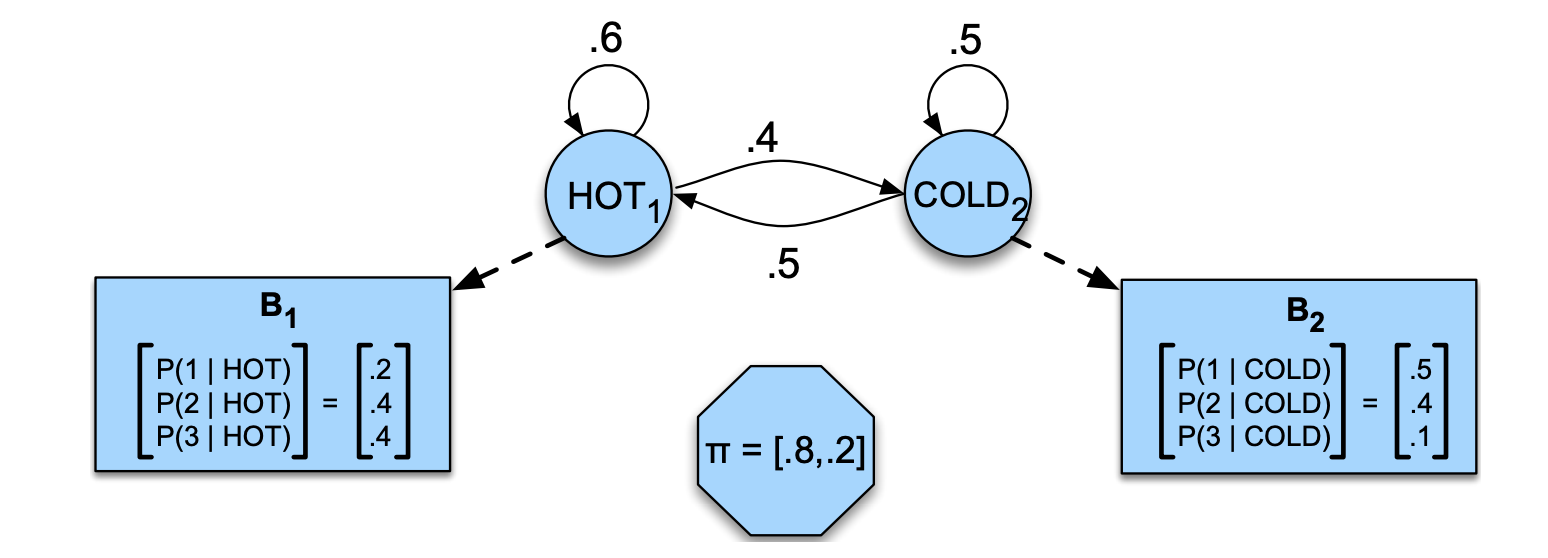

There are three fundamental problems for HMMs:

1) **Decoding**: Given the model parameters and observed data, estimate the optimal sequence of hidden states. 

2) **Likelihood**: Given the model parameters and observed data, calculate the likelihood of the data. 

3) **Learning**: Given just the observed data, estimate the model parameters.

https://www.cs.ubc.ca/~murphyk/Bayes/rabiner.pdf


#### Discrete HMM

In [8]:


states = ["Rainy", "Sunny"]
n_states = len(states)
observations = ["walk", "shop", "clean"]
n_observations = len(observations)
start_probability = np.array([0.6, 0.4])
transition_probability = np.array([[0.7, 0.3], [0.4, 0.6]])
emission_probability = np.array([[0.1, 0.4, 0.5], [0.6, 0.3, 0.1]])


def _get_markov_edges(Q):
    """
    function that maps transition probability dataframe
    to markov edges and weights
    """
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges


def generate_random_seq_of_observations():
    seq = deque()
    lengths = deque()
    for _ in range(100):
        length = random.randint(5, 10)
        lengths.append(length)
        for _ in range(length):
            r = random.random()
            if r < 0.2:
                seq.append(0)  # walk
            elif r < 0.6:
                seq.append(1)  # shop
            else:
                seq.append(2)  # clean
    seq = np.array([seq]).T
    return seq, lengths


def is_converged(hmm_model):
    return hmm_model.monitor_.converged


def train_discrete_hmm(
    X,
    lengths,
    start_probability,
    transition_probability,
    emission_probability,
    components=3,
    iterations=15,
    verbose=True,
):
    model = MultinomialHMM(components, iterations, verbose, init_params="mc")
    model.startprob_ = start_probability
    model.transmat_ = transition_probability
    model.emissionprob_ = emission_probability
    print(
        f"commencing hmm model training with parameters- "
        f"Iterations: {iterations}, components: {components}"
    )
    model.fit(X, lengths)
    if is_converged(model):
        print("model has converged")
        print(' ')
        print(model.transmat_)
        print(model.emissionprob_)
        print(model.startprob_)
    return model


def decode_hidden_state_for_discrete_hmm(encoded_obs_seq, observations, states, model):
    logprob, hidden_states = model.decode(encoded_obs_seq, algorithm="viterbi")
    print(
        "Observed behaviour:",
        ", ".join(map(lambda x: observations[x], encoded_obs_seq.T[0])),
    )
    print("Inferred hidden states:", ", ".join(map(lambda x: states[x], hidden_states)))
    return logprob, hidden_states



###### Given just the observed data, estimate the model parameters.

In [9]:
seq, lengths = generate_random_seq_of_observations()

In [10]:
        model = train_discrete_hmm(
            seq,
            lengths,
            start_probability,
            transition_probability,
            emission_probability,
            components=n_states,
            iterations=30,
            verbose=True,
        )

commencing hmm model training with parameters- Iterations: 30, components: 2
model has converged
 
[[0.75503773 0.24496227]
 [0.51204882 0.48795118]]
[[0.05456324 0.4129835  0.53245326]
 [0.37760948 0.46097038 0.16142014]]
[0.60842602 0.39157398]


###### Given the model parameters and observed data, estimate the optimal sequence of hidden states.

In [11]:
obs_states = np.array([[0, 2, 1, 1, 2, 0]]).T
decode_hidden_state_for_discrete_hmm(obs_states, observations, states, model)


Observed behaviour: walk, clean, shop, shop, clean, walk
Inferred hidden states: Sunny, Rainy, Rainy, Rainy, Rainy, Sunny


(-8.833534921009988, array([1, 0, 0, 0, 0, 1], dtype=int32))

#### HMM for Regime Detection


HMM can also be used for regime detection in time series stock data. Market conditions can change over time leading to up-beat (bullish) or down-beat (bearish) market sentiments (regimes).Since regimes of the total market are not observable and the return can be calculated directly, the modelling paradigm of hidden Markov model is introduced to capture the tendency of financial markets which change their behavior abruptly. Decoding the regimes can help in forecasting future market conditions


In this section we will fit a Gaussian HMM to yahoo stock market data and then decode the hidden states (regimes) from the observed returns



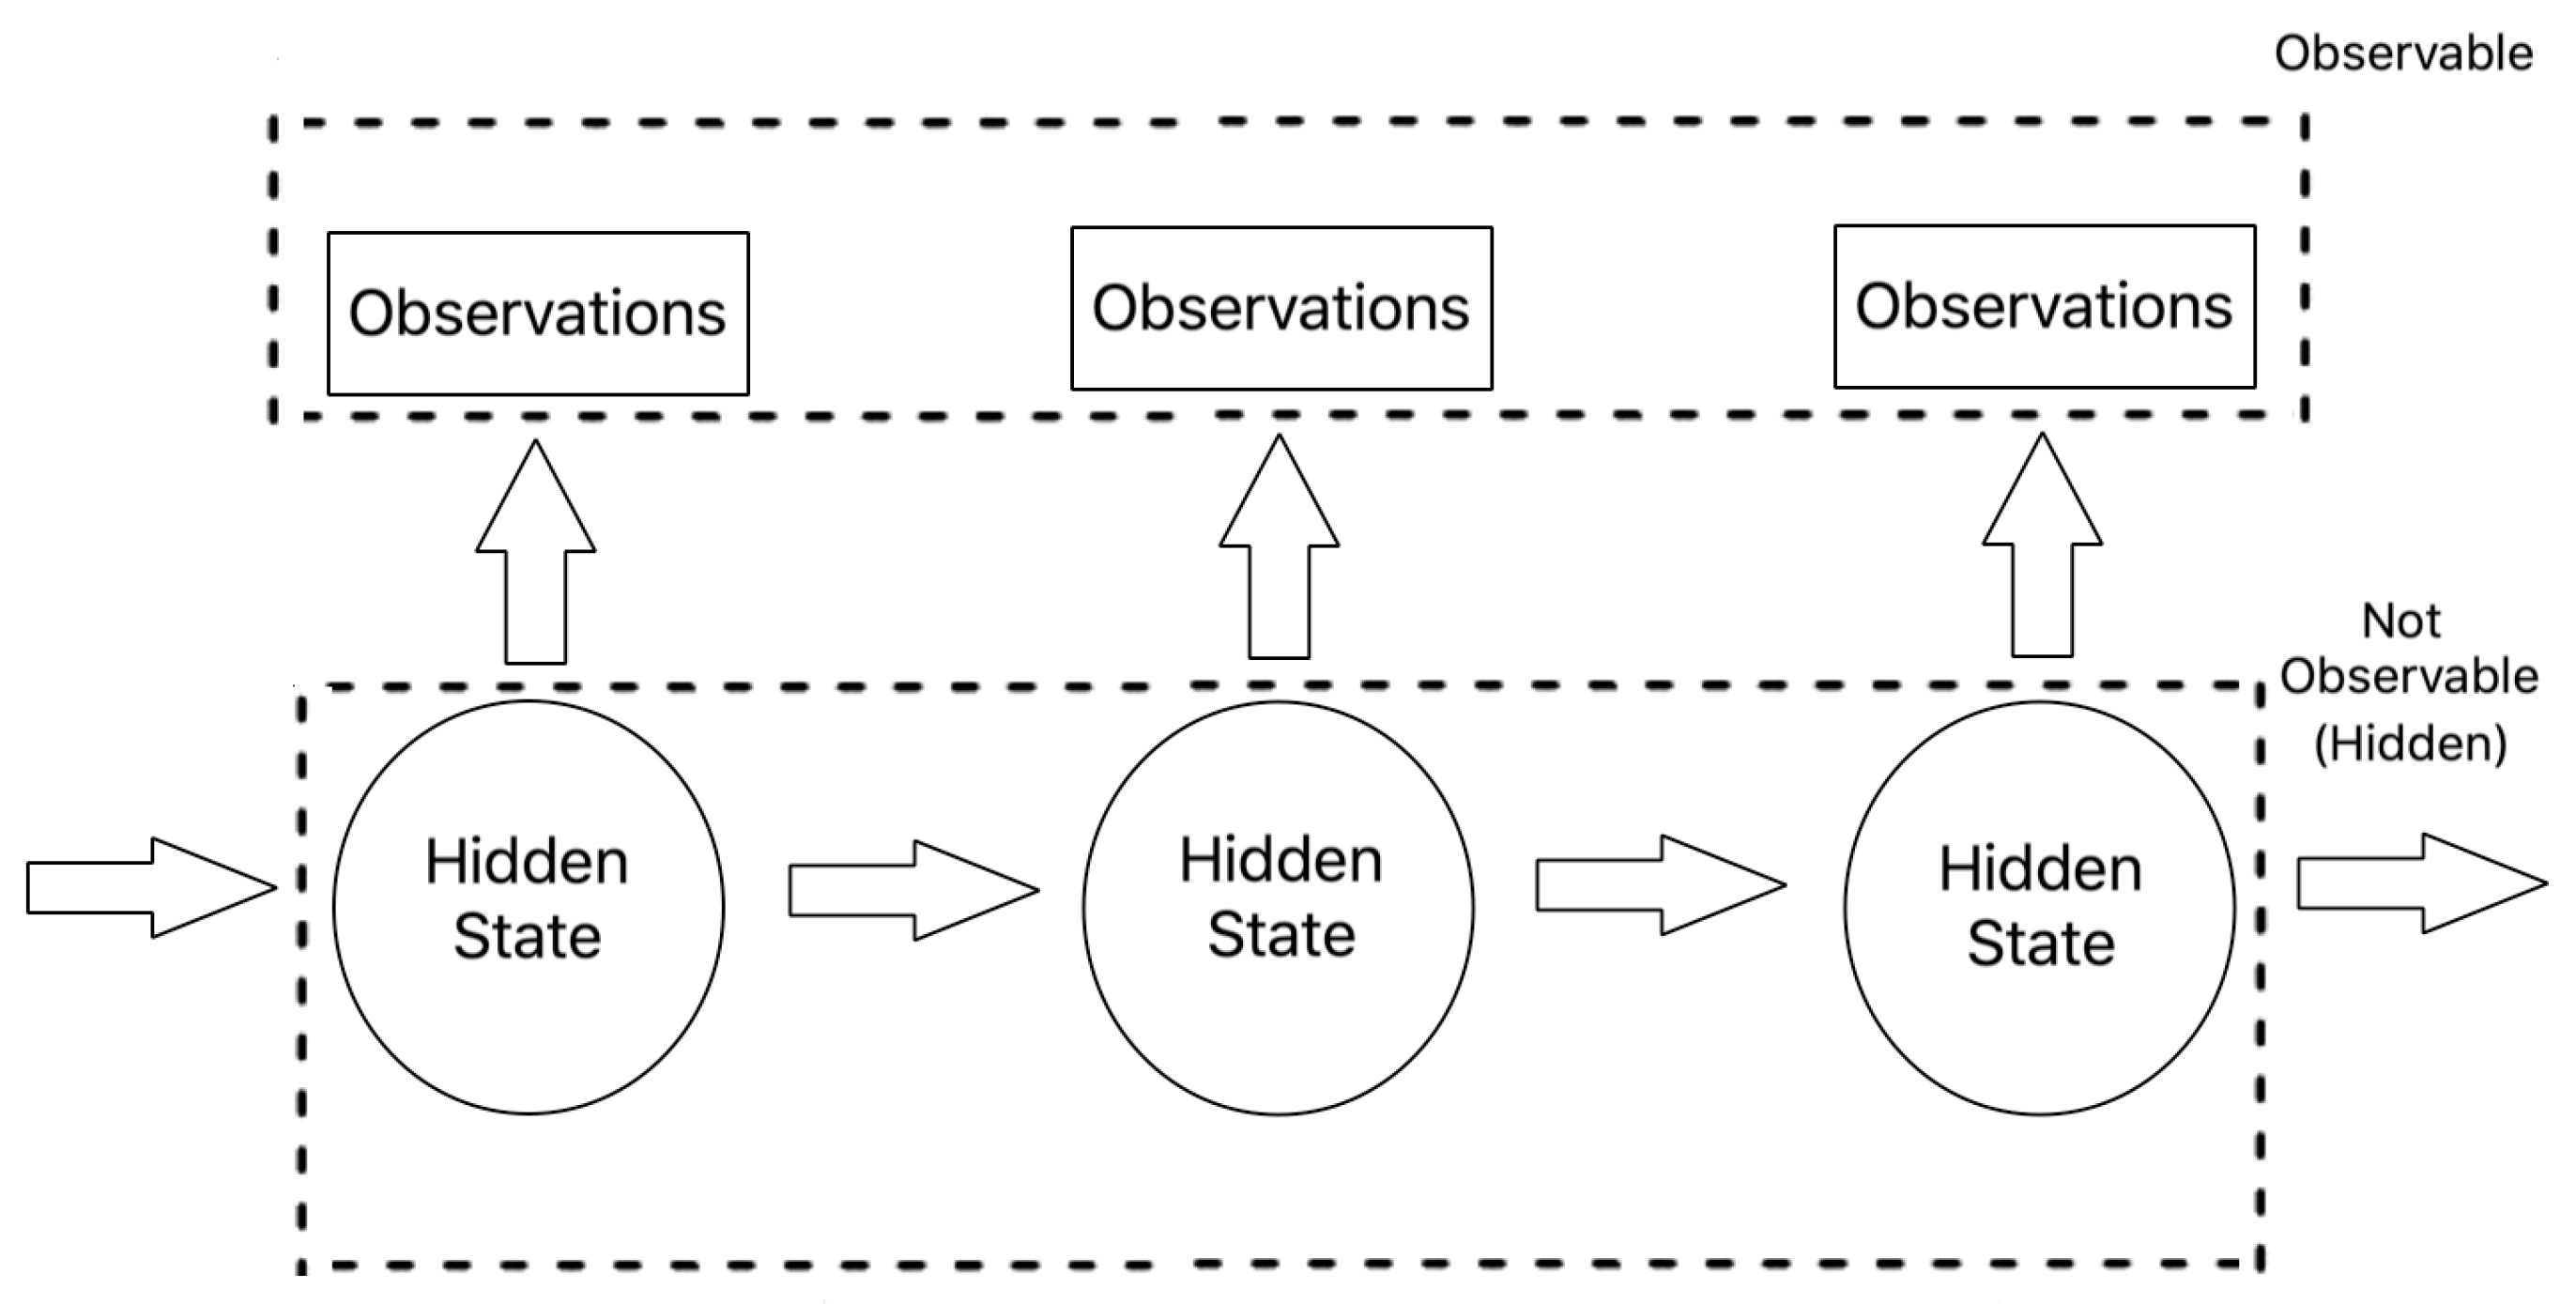

In [12]:
def get_quotes_data_finance(start, end):

    Stocks = web.DataReader('GE', 'yahoo', start=start, end=end) 
    Stocks.reset_index(inplace=True, drop=False)
    Stocks = Stocks.drop(["Open", "High", "Low", "Adj Close"], axis=1)
    return Stocks


def preprocess_data(Stocks):
    Stocks = list(Stocks.itertuples(index=False, name=None))
    dates = np.array([q[0] for q in Stocks])
    end_val = np.array([q[1] for q in Stocks])
    volume = np.array([q[2] for q in Stocks])[1:]
    return dates, end_val, volume
    

def plot_stocks_data(dates, end_val):
    plt.figure(figsize=(15, 5), dpi=100)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.plot_date(dates, end_val, "-")
    plt.show()

def compute_end_val_delta(dates, end_val, volume):
    diff = np.diff(end_val)
    X = np.column_stack([diff, volume])
    return X


def train_gaussian_hmm(X, components, iterations):
    model = GaussianHMM(
        n_components=components, covariance_type="diag", n_iter=iterations
    ).fit(X)
    return model


def compute_mean_and_vars_hidden_state(model):
    for i in range(model.n_components):
        print("{0}th hidden state".format(i))
        print("mean = ", model.means_[i])
        print("var = ", np.diag(model.covars_[i]))

def decode_hidden_states_time_series(X, model):
    hidden_states = model.predict(X)
    print(model.transmat_)
    return hidden_states


def plot_trained_parameters(model, hidden_states, dates, end_val, figsize):
    fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=figsize)
    colours = cm.rainbow(np.linspace(0, 1, model.n_components))
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        # Use fancy indexing to plot data in each state.
        mask = hidden_states == i
        ax.plot_date(dates[mask], end_val[mask], ".-", c=colour)
        ax.set_title(f"hidden state {i+1}")

        # Format the ticks.
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()


Here the pandas_datareader library is used to fetch Yahoo Finance provides stock market data but has a rich source of stockd and shares data from various platforms. 
https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [13]:
start_date = datetime.date(2017, 7, 1)
end_date = datetime.datetime.now()

stocks = get_quotes_data_finance(start_date, end_date)
dates, end_val, volume = preprocess_data(stocks)
X = compute_end_val_delta(dates, end_val, volume)
stocks

,Date,Close,Volume
0,2017-07-03,211.153839,2686450.0
1,2017-07-05,210.384613,2765126.0
2,2017-07-06,202.384613,9963967.0
3,2017-07-07,201.153839,5270603.0
4,2017-07-10,200.307693,6078176.0
...,...,...,...
1095,2021-11-05,108.739998,7600000.0
1096,2021-11-08,108.419998,5174500.0
1097,2021-11-09,111.290001,25123700.0
1098,2021-11-10,108.959999,8692600.0


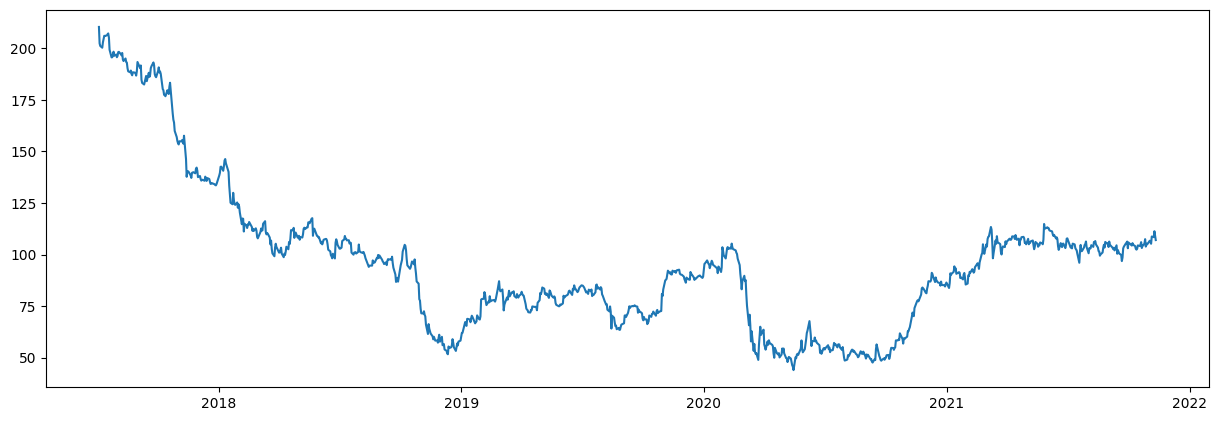

In [14]:
dates = dates[1:] 
end_val = end_val[1:]
plot_stocks_data(dates, end_val)
plt.show()

In [15]:
components=5
iterations=100000



model = train_gaussian_hmm(X, components,iterations)
hidden_states = decode_hidden_states_time_series(X, model)


[[6.57402350e-01 1.12900192e-01 1.69681421e-02 2.03963970e-01
  8.76534554e-03]
 [2.09671133e-01 5.86090633e-01 6.08561874e-02 4.76268817e-21
  1.43382046e-01]
 [3.53992673e-03 2.08330839e-01 3.49237653e-01 8.06791520e-31
  4.38891581e-01]
 [2.64169410e-01 3.40050779e-02 2.22110819e-02 6.79613566e-01
  8.64840433e-07]
 [1.07078759e-02 3.03278718e-01 6.89313942e-02 3.58296062e-61
  6.17082011e-01]]


In [16]:
compute_mean_and_vars_hidden_state(model)

0th hidden state
mean =  [5.65368930e-02 7.24052142e+06]
var =  [2.75339545e+00 1.29787375e+12]
1th hidden state
mean =  [-7.73451415e-02  1.04803184e+07]
var =  [4.30021783e+00 2.49036861e+12]
2th hidden state
mean =  [-5.75352739e-01  2.66880279e+07]
var =  [2.75298996e+01 5.90433600e+13]
3th hidden state
mean =  [-1.3495148e-01  4.9457760e+06]
var =  [1.01867685e+00 1.08033776e+12]
4th hidden state
mean =  [-1.96078559e-01  1.57212737e+07]
var =  [8.83788229e+00 8.26204841e+12]


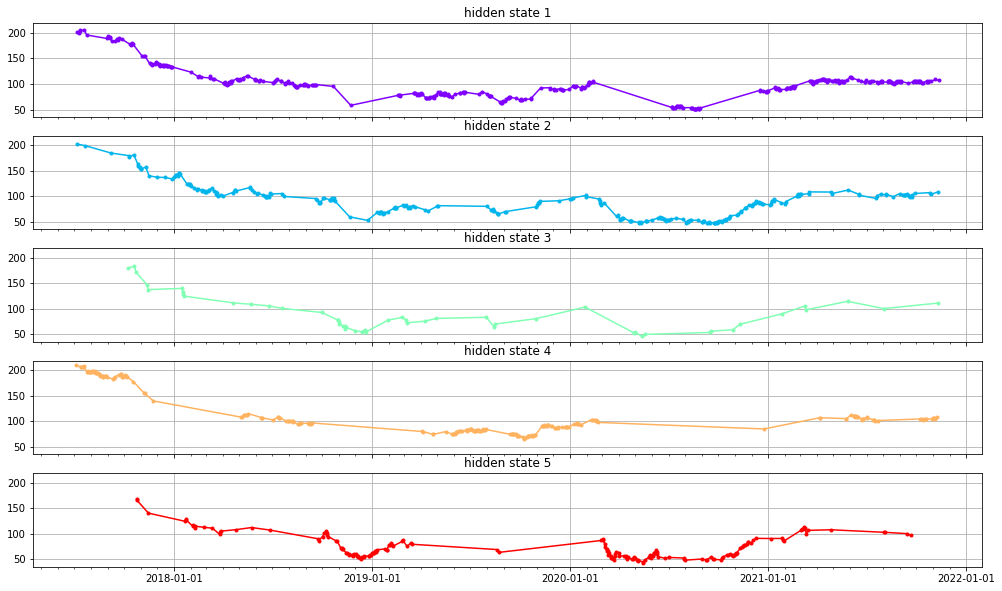

In [17]:

plot_trained_parameters(model, hidden_states, dates, end_val, (17,10))

### Markov Networks/Random fields

Markov networks (sometimes called Markov random fields) are probabilistic models that are typically represented using an **undirected** graph. Each of the nodes in the graph represents a variable in the data and each of the edges represent an associate. Unlike Bayesian networks which have directed edges and clear directions of causality, Markov networks have undirected edges and only encode associations.


In [18]:
from pgmpy.models import MarkovNetwork
mm = MarkovNetwork()
mm.add_nodes_from(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'])
mm.add_edges_from([('x1', 'x3'), ('x1', 'x4'), ('x2', 'x4'),
                   ('x2', 'x5'), ('x3', 'x6'), ('x4', 'x6'),
                   ('x4', 'x7'), ('x5', 'x7')])
nt = draw_network(mm, "red", "green", notebook=True, physics=True, config=None)
nt.show('outputs/markov_network.html')
       

In [19]:
mm.get_local_independencies()

(x1 ⟂ x2, x5, x7, x6 | x3, x4)
(x2 ⟂ x1, x3, x7, x6 | x5, x4)
(x3 ⟂ x2, x5, x4, x7 | x1, x6)
(x4 ⟂ x5, x3 | x1, x6, x7, x2)
(x5 ⟂ x1, x3, x4, x6 | x2, x7)
(x6 ⟂ x1, x5, x7, x2 | x3, x4)
(x7 ⟂ x1, x3, x6, x2 | x5, x4)

##### Normalising the joint distribution


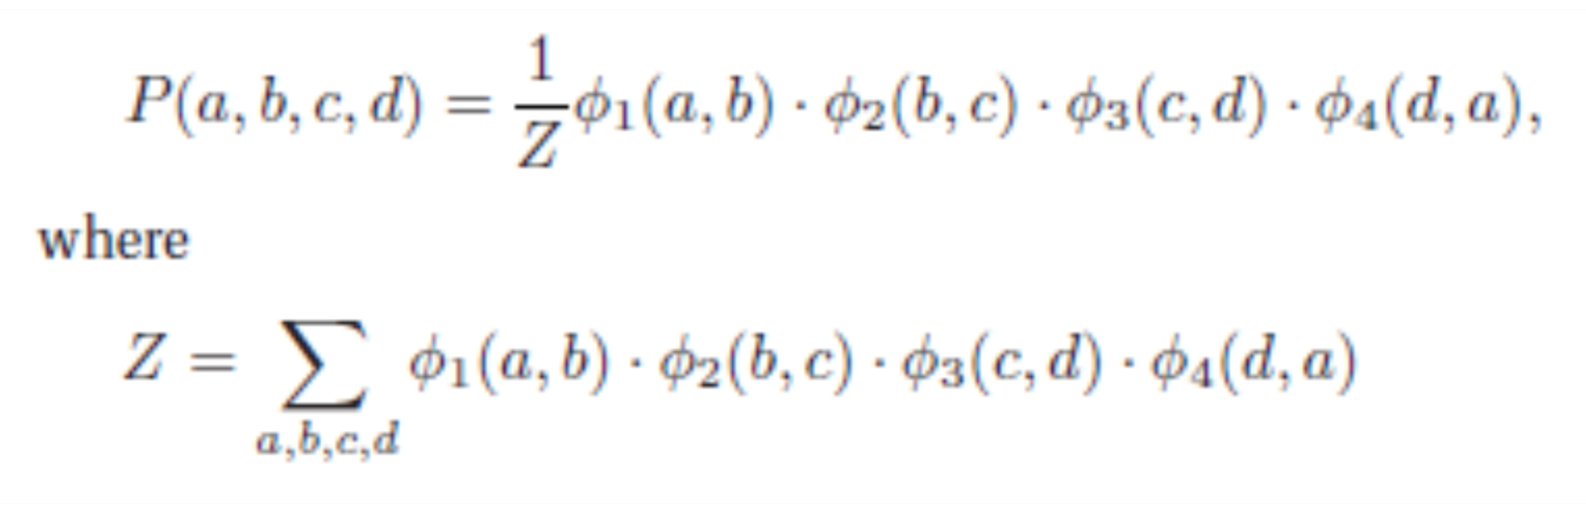

In [21]:
from pgmpy.factors.discrete import DiscreteFactor

phi = [DiscreteFactor(edge, cardinality=[2, 2], values=np.random.rand(4)) for edge in mm.edges()]
mm.add_factors(*phi)
mm.get_partition_function()

1.1337004072341905